In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pylab import *
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import beta
from scipy import special
from scipy import optimize
import pymc3 as pm
import seaborn as sns

## Exploratory Analysis

We first plot the data to see what everything looks like. From the plot below, we see that var2 and var3 are obviously linearly related. There is maybe a slight linear relation among Y and var1, but not obviously for the other variables. Y is obviously not a logit function, nor does it look to have a gaussian dependence on the different variables. Based on the data, we will assume that we are fitting a linear model $Y = \alpha_0 + \alpha_1\,var1 + \alpha_2\,var2 + \alpha_3\,var3$.

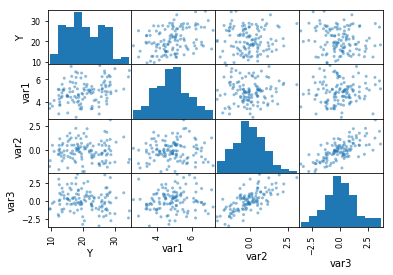

In [2]:
df = pd.read_csv('ProjectData.csv', delimiter = '\t')
pd.plotting.scatter_matrix(df)
plt.savefig('ScatterPlot.png')
plt.show()

In [112]:
df_std = pd.DataFrame(columns = ['std_y', 'std_x1', 'std_x2', 'std_x3'])
def standardize(series):
    return (series - series.mean())/(series.std())
for std_col, col in zip(df_std.columns, df.columns):
    df_std[std_col] = standardize(df[col])
df_std.head()

,std_y,std_x1,std_x2,std_x3
0,-1.685834,-0.773991,-0.077024,-0.128445
1,-1.778432,-1.287208,0.549056,-0.273667
2,-1.145631,0.275933,-0.032525,0.483973
3,-1.207690,0.151908,0.739702,0.832828
4,-1.157411,0.146334,-0.775590,-0.811931


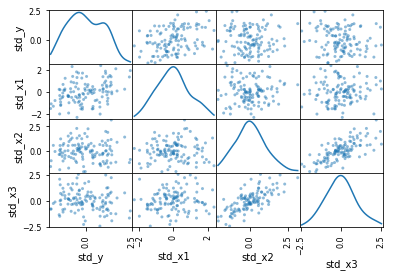

In [324]:
X1 = df_std['std_x1']
X2 = df_std['std_x2']
X3 = df_std['std_x3']
Y = df_std['std_y']
pd.plotting.scatter_matrix(df_std, diagonal = 'kde')
#plt.savefig('ScatterPlot.png')
plt.show()

In [327]:
from scipy.stats.stats import pearsonr
pearsonr(X2, X3)

(0.70935249029411163, 2.4765574512376231e-19)

## A simple model: a single gaussian fit

In [ ]:
# think about if Bayesian stats suppose the \alpha and \betas have distributions, or if the x's do. That is, because
# either x's or the variables follow normal distributions, that implies so will y.  

We will do a simple linear regression for the data here, with the model $Y = \alpha + \beta1*x1 + \beta2*var2 + \beta3*var3$. The frequentist approach would just fit the data to extract $\alpha$ and the $\beta_i$s. The Bayesian way is to give each variable ($\alpha, \beta_i$) a distribution, and via Monte Carlo simulations we should be able to model the spread in the data as well as the mean. If we assume these distributions follow $\alpha = N(\bar{\alpha}, \sigma_1)$, $\beta_i = N(\bar{\beta_i}, \sigma_i)$, then for this simple model, $Y \sim N(\mu, \sigma^2)$. Here, $\mu(\vec{x}) = \bar{\alpha} + \bar{\beta1}*var1 + \bar{\beta2}*var2 + \bar{\beta3}*var3$, and $\sigma = $ (see Vanja's notes first few classes). We weakly inform our priors based on the scatter plot above.

In [118]:
from pymc3 import Model, Normal, HalfNormal

with pm.Model() as basic_model:
    # Priors
    alpha = Normal('alpha', mu=0, sd=1)
    beta1 = Normal('beta1', mu=0, sd=1)
    beta2 = Normal('beta2', mu=0, sd=1)
    beta3 = Normal('beta3', mu=0, sd=1)
    sigma = HalfNormal('sigma', sd=1)
    # Expected value of outcome
    mu = alpha + beta1*X1 + beta2*X2 + beta3*X3
    y_obs = Normal('y_obs', mu=mu, sd=sigma, observed=Y)
    
    trace = pm.sample(10000, chains=2)
    
    # MAP estimate of parameters:
#    mean = pm.find_MAP(model=basic_model)
#    hess = pm.find_hessian(mean, vars = [alpha, beta1, beta2, beta3])
#    cov = np.linalg.inv(hess)
#    print(mean)
#    print(hess)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]
100%|██████████| 10500/10500 [00:30<00:00, 344.73it/s]


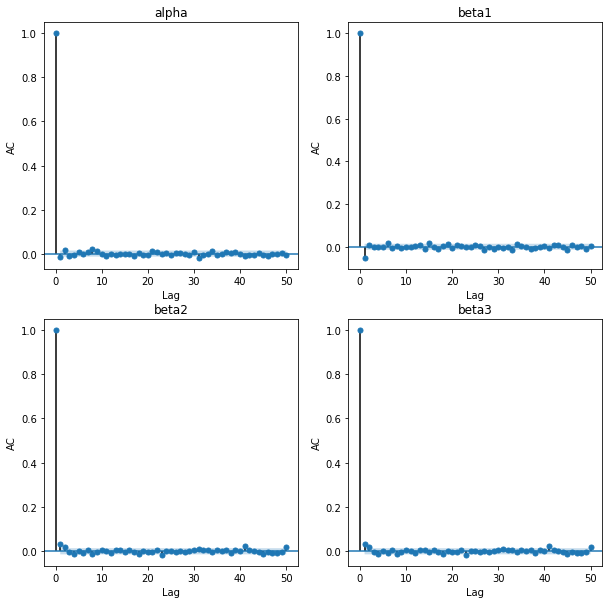

In [119]:
fig, ax = plt.subplots(2,2, figsize = (10,10))

statsmodels.graphics.tsaplots.plot_acf(trace['alpha'], ax = ax[0,0], use_vlines = True, lags = 50)
#    ax[2].acorr(samples, normed = True)
ax[0,0].set_ylabel('AC')
ax[0,0].set_xlabel('Lag')
ax[0,0].set_title('alpha')

statsmodels.graphics.tsaplots.plot_acf(trace['beta1'], ax = ax[0,1], use_vlines = True, lags = 50)
#    ax[2].acorr(samples, normed = True)
ax[0,1].set_ylabel('AC')
ax[0,1].set_xlabel('Lag')
ax[0,1].set_title('beta1')

statsmodels.graphics.tsaplots.plot_acf(trace['beta3'], ax = ax[1,0], use_vlines = True, lags = 50)
#    ax[2].acorr(samples, normed = True)
ax[1,0].set_ylabel('AC')
ax[1,0].set_xlabel('Lag')
ax[1,0].set_title('beta2')

statsmodels.graphics.tsaplots.plot_acf(trace['beta3'], ax = ax[1,1], use_vlines = True, lags = 50)
#    ax[2].acorr(samples, normed = True)
ax[1,1].set_ylabel('AC')
ax[1,1].set_xlabel('Lag')
ax[1,1].set_title('beta3')

plt.savefig('Simplemodel_ACF.png')

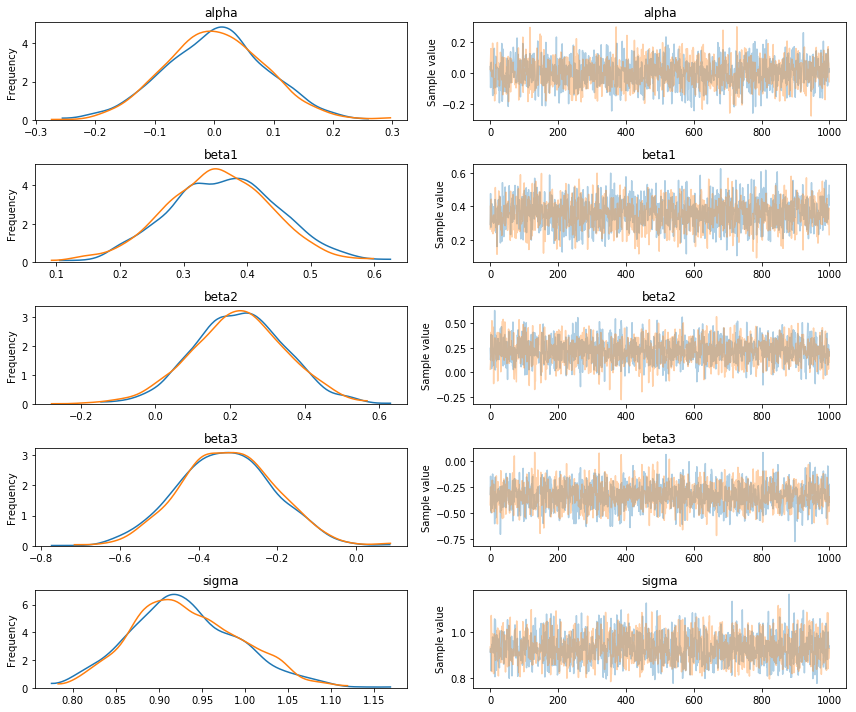

In [120]:
pm.traceplot(trace[::10]);
plt.savefig('SimpleModel_ParamResults.png')

In [121]:
pm.summary(trace[::10])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.001802,0.084869,0.002119,-0.158090,0.170083,1856.052612,0.999502
beta1,0.358127,0.084824,0.002024,0.184993,0.514216,1783.253201,1.004184
beta2,0.221837,0.123444,0.002826,-0.024759,0.456405,1973.368946,1.000036
beta3,-0.330141,0.120207,0.002492,-0.556291,-0.097769,2005.484777,1.000728
sigma,0.930630,0.062090,0.001204,0.811764,1.047576,2041.732749,1.000190


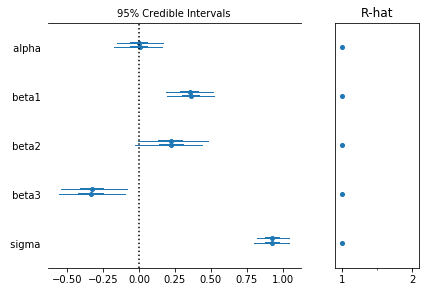

In [122]:
pm.forestplot(trace[::10]);
plt.savefig('SimpleModel_ParamResultsb.png')

We can look at how well our simulation models the observed data, including the mean and the tails. To do this, we simulate the predictive posterior for 5000 different combinations of alpha, beta_i (each of length ~100) and look at the histogram. We can also look at how the mean of the predictive posterior (for different alpha, beta_i) compares to the mean of our data. From these, we can see that the single gaussian model correctly determines the mean but the tails are not well modeled. Because of this, we instead move on to a mixture model.

In [123]:
with basic_model:
    ppc = pm.sample_posterior_predictive(trace[::10], 5000)

100%|██████████| 5000/5000 [00:09<00:00, 548.77it/s]


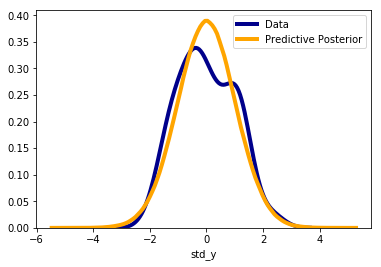

In [342]:
sns.distplot(Y, hist=False, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label': 'Data'})

sns.distplot(np.transpose(ppc['y_obs']).flatten(), hist=False, kde=True, 
             bins=40, color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label': 'Predictive Posterior'}, axlabel = None)

plt.savefig('SimpleModel_Yhist.png')

We can judge the results of our fit by a few methods. One is to look at how well our simulated results predict the mean of y. To do this, we calculate the predictive posterior. This code picks parameters of alpha and beta given our trace and generates ~100 samples given those values of alpha and beta. We do this for 500 different parameter values. We then look at the mean of each of those chains and compare it to the mean of the data. We see below that they are very similar.

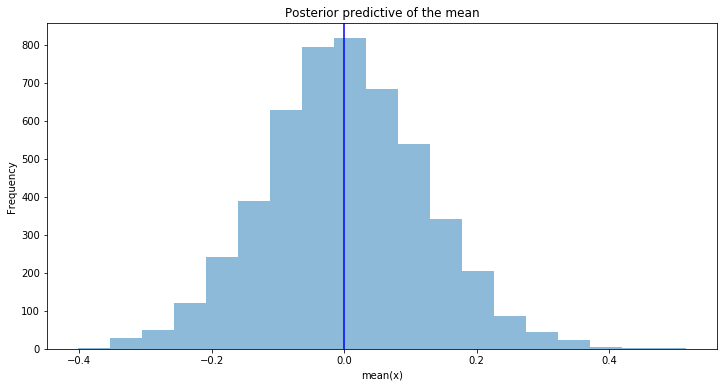

In [128]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['y_obs']], bins=19, alpha=0.5)
ax.axvline(Y.mean(), color = 'blue')
#ax.hist(df['Y'], bins = 19, alpha = 0.5)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');
plt.savefig('SimpleModel_Meancomparison.png')

## Reverting back to original scale:

In [344]:
pm.summary(trace[::10])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.001802,0.084869,0.002119,-0.158090,0.170083,1856.052612,0.999502
beta1,0.358127,0.084824,0.002024,0.184993,0.514216,1783.253201,1.004184
beta2,0.221837,0.123444,0.002826,-0.024759,0.456405,1973.368946,1.000036
beta3,-0.330141,0.120207,0.002492,-0.556291,-0.097769,2005.484777,1.000728
sigma,0.930630,0.062090,0.001204,0.811764,1.047576,2041.732749,1.000190


In [411]:
.36*6

2.16

In [410]:
df['Y'].std(), df['var1'].std()

(5.7758769847492131, 0.97558672085122933)

In [415]:
# source: https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
def UnStandardize(intercept, slopes, sigma, or_Y, or_xs):
    '''
    takes the trace results for the intercept and slopes of an MCMC algorithm using standardized data, as well
    as the original unstandardized data (output or_Y, inputs or_xs), and returns the scaled results upon which
    means, standard deviations, and HPDs can be calculated.
    Assumes regression is Y ~ N(mu, sigma^2)
    '''
    suma = [slopes[i]*or_Y.std()/or_xs[i].std()*or_xs[i].mean() for i in range(len(or_xs))]
    intercept_orig = intercept*or_Y.std() + or_Y.mean() - sum(suma, axis=0)
    slopes_orig = [slopes[i]*or_Y.std()/or_xs[i].std() for i in range(len(or_xs))]
    sigma_orig = sigma*or_Y.std()
    
    return np.array(sigma_orig), np.array(intercept_orig), np.array(slopes_orig)

intercept_simple = trace[::10]['alpha']
slope_var1_simple = trace[::10]['beta1']
slope_var2_simple = trace[::10]['beta2']
slope_var3_simple = trace[::10]['beta3']
sigma_simple = trace[::10]['sigma']
sigma_orig, int_orig, slopes_orig = UnStandardize(intercept_simple, np.array([slope_var1_simple, slope_var2_simple, slope_var3_simple]), sigma_simple, df['Y'], np.array([df['var1'],df['var2'], df['var3']]))
#int_mean, slopes_mean = UnStandardize(intercept_simple.mean(), np.array([slope_var1_simple.mean(), slope_var2_simple.mean(), slope_var3_simple.mean()]), df['Y'], np.array([df['var1'],df['var2'], df['var3']]))
#print(int_mean, slopes_mean)
means = [int_orig.mean(), slopes_orig[0].mean(),slopes_orig[1].mean(),slopes_orig[2].mean(), sigma_orig.mean()]
stds = [int_orig.std(), slopes_orig[0].std(),slopes_orig[1].std(),slopes_orig[2].std(), sigma_orig.std()]
hpds_l = [pm.stats.hpd(int_orig)[0],pm.stats.hpd(slopes_orig[0])[0],pm.stats.hpd(slopes_orig[1])[0],pm.stats.hpd(slopes_orig[2])[0],pm.stats.hpd(sigma_orig)[0]]
hpds_h = [pm.stats.hpd(int_orig)[1],pm.stats.hpd(slopes_orig[0])[1],pm.stats.hpd(slopes_orig[1])[1],pm.stats.hpd(slopes_orig[2])[1],pm.stats.hpd(sigma_orig)[1]]

data = {'mean': means, 'std': stds, 'hpd_2.5': hpds_l, 'hpd_97.5': hpds_h}
trace_unst = pd.DataFrame(data=data, columns = ['mean', 'std', 'hpd_2.5', 'hpd_97.5'], index = ['alpha', 'beta1', 'beta2', 'beta3', 'sigma'])
trace_unst

,mean,std,hpd_2.5,hpd_97.5
alpha,10.340305,2.500799,5.050795,14.882790
beta1,2.129301,0.504333,1.099907,3.057353
beta2,1.269208,0.706269,-0.141655,2.611250
beta3,-1.336330,0.486568,-2.251732,-0.395747
sigma,5.375206,0.358625,4.688651,6.050670


### Compare with non-standardized trace results:

In [400]:
from pymc3 import Model, Normal, HalfNormal

with pm.Model() as basic_model_unstd:
    # Priors
    alpha = Normal('alpha', mu=0, sd=10)
    beta1 = Normal('beta1', mu=0, sd=10)
    beta2 = Normal('beta2', mu=0, sd=10)
    beta3 = Normal('beta3', mu=0, sd=10)
    sigma = HalfNormal('sigma', sd=10)
    # Expected value of outcome
    mu = alpha + beta1*df['var1'] + beta2*df['var2'] + beta3*df['var3']
    y_obs = Normal('y_obs', mu=mu, sd=sigma, observed=df['Y'])
    
    trace_unstd = pm.sample(10000, chains=2)
    
    # MAP estimate of parameters:
#    mean = pm.find_MAP(model=basic_model)
#    hess = pm.find_hessian(mean, vars = [alpha, beta1, beta2, beta3])
#    cov = np.linalg.inv(hess)
#    print(mean)
#    print(hess)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]
100%|██████████| 10500/10500 [01:28<00:00, 119.30it/s]


In [402]:
with basic_model_unstd:
    ppc_unstd = pm.sample_posterior_predictive(trace_unstd[::10], 5000)

100%|██████████| 5000/5000 [00:10<00:00, 488.12it/s]


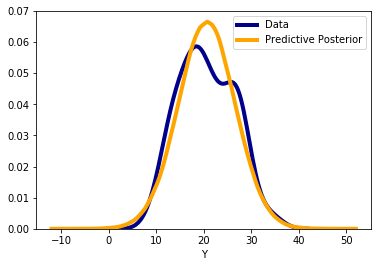

In [403]:
sns.distplot(df['Y'], hist=False, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label': 'Data'})

sns.distplot(np.transpose(ppc_unstd['y_obs']).flatten(), hist=False, kde=True, 
             bins=40, color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label': 'Predictive Posterior'}, axlabel = None)

In [401]:
pm.summary(trace_unstd[::10])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,9.729242,2.453874,0.053425,4.564813,14.329521,1799.668348,1.000747
beta1,2.246808,0.489898,0.010610,1.216883,3.170837,1824.013276,1.000595
beta2,1.306772,0.706357,0.017441,0.017351,2.787061,1815.539580,1.000393
beta3,-1.366684,0.501441,0.011616,-2.342946,-0.400547,1882.453990,1.000370
sigma,5.388765,0.371654,0.008607,4.627021,6.072327,1989.584367,0.999588


## Mixture model:

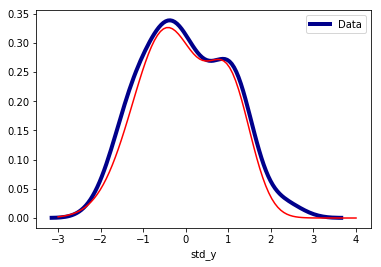

In [456]:
import scipy
xs = np.linspace(-3,4,100)
ys = .25*scipy.stats.norm.pdf(xs, 1.05, .5) + .65*scipy.stats.norm.pdf(xs, -.45, .8)
fig, ax = plt.subplots(1)
sns.distplot(Y, hist=False, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label': 'Data'},ax=ax)
ax.plot(xs,ys, 'r-')

We'll first try 2 mixture components to test out the mixture model.

In [14]:
df_std = pd.DataFrame(columns = ['std_y', 'std_x1', 'std_x2', 'std_x3'])
def standardize(series):
    return (series - series.mean())/(series.std())
for std_col, col in zip(df_std.columns, df.columns):
    df_std[std_col] = standardize(df[col])
df_std.head()

,std_y,std_x1,std_x2,std_x3
0,-1.685834,-0.773991,-0.077024,-0.128445
1,-1.778432,-1.287208,0.549056,-0.273667
2,-1.145631,0.275933,-0.032525,0.483973
3,-1.207690,0.151908,0.739702,0.832828
4,-1.157411,0.146334,-0.775590,-0.811931


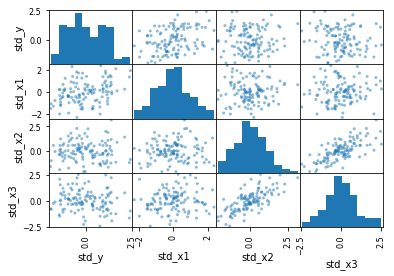

In [15]:
pd.plotting.scatter_matrix(df_std)
plt.show()

In [16]:
X1 = df_std['std_x1']
X2 = df_std['std_x2']
X3 = df_std['std_x3']
Y = df_std['std_y']

## Tighter restrictions on priors:

In [66]:
from pymc3 import Model, Normal, HalfNormal, Beta
from theano import tensor as tt




with pm.Model() as mixture_model_b:
    # Priors
    
 #   BoundedPrior = pm.Bound(pm.Cauchy, lower = -5, upper = 5)
 #   alpha_a = BoundedPrior('alpha_a', alpha=1.15, beta=2.5, shape = 2)
 #   alpha_b = BoundedPrior('alpha_b', alpha=-.5, beta=2.5, shape = 2)
 #   beta1 = BoundedPrior('beta1', alpha=0, beta=0.75, shape = 2)
 #   beta2 = BoundedPrior('beta2', alpha=0, beta=0.75, shape = 2)
#  beta3 = pm.Cauchy('beta3', alpha=0, beta=0.75, shape = 2)
#    BoundedNoise = pm.Bound(pm.HalfCauchy, lower = 0, upper = 4)
#    sigma = BoundedNoise('sigma', beta=0.75, shape = 2)
    
 #   alpha_a = pm.Cauchy('alpha_a', alpha=0, beta=2.5, shape = 1)
 #   alpha_b = pm.Cauchy('alpha_b', alpha=0, beta=2.5, shape = 1)
    alpha = pm.Cauchy('alpha', alpha=0, beta=1.2, shape=2)
    beta1 = pm.Cauchy('beta1', alpha=0, beta=1.2, shape = 2)
    beta2 = pm.Cauchy('beta2', alpha=0, beta=1.2, shape = 2)
    sigma = pm.HalfCauchy('sigma', beta=1.0, shape = 2)
    
    # Expected value of outcome
    mu = tt.stack([alpha[0] + beta1[0]*X1 + beta2[0]*X2, 
                   alpha[1] + beta1[1]*X1 + beta2[1]*X2], axis = 1)
    
    order_means_potential = pm.Potential('order_means_potential', tt.switch(mu[0] - mu[1] < 0, -np.inf, 0))
    
    # weights
#    BoundedWeights = pm.Bound(pm.Dirichlet, lower=0.1, upper = 0.9)
   # BoundedWeights = pm.Bound(pm.Beta, lower=0.1, upper = 0.9)
   # beta = BoundedWeights('beta', alpha = 7., beta = 3, shape = 2)
 #   w = np.array([beta, 1-beta])
    w = pm.Dirichlet('w', np.array([1, 1]))
#    w = BoundedWeights('w', a = np.array([1,1]))

    y_obs = pm.NormalMixture('y_obs', w, mu, sd=sigma, comp_shape = (2,), observed=Y)
    
#    step = pm.Metropolis()
    trace2b = pm.sample(10000, init = 'advi_map', chains=1, random_seed = 2, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
/usr/local/lib/python3.5/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -177.19, ||grad|| = 27.914: 100%|██████████| 10/10 [00:00<00:00, 714.86it/s]
Average Loss = inf:   6%|▌         | 11091/200000 [00:31<09:04, 346.64it/s]   
Convergence achieved at 11100
Interrupted at 11,099 [5%]: Average Loss = 191.67
Sequential sampling (1 chains in 1 job)
NUTS: [w, sigma, beta2, beta1, alpha]
100%|██████████| 10500/10500 [02:49<00:00, 61.77it/s] 
There were 5226 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence ch

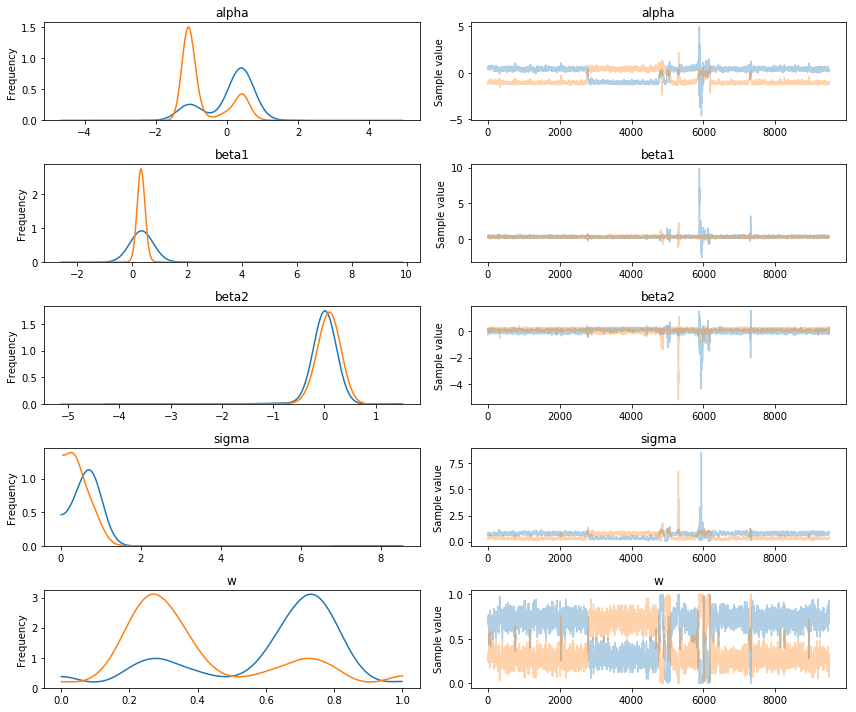

In [69]:
#fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,3))
ax = pm.traceplot(trace2b[:9500])

## Trying 2 long chains...

In [73]:
from pymc3 import Model, Normal, HalfNormal, Beta
from theano import tensor as tt




with pm.Model() as mixture_model_c:
    # Priors
    alpha = pm.Cauchy('alpha', alpha=0, beta=1.2, shape=2)
    beta1 = pm.Cauchy('beta1', alpha=0, beta=1.2, shape = 2)
    beta2 = pm.Cauchy('beta2', alpha=0, beta=1.2, shape = 2)
    sigma = pm.HalfCauchy('sigma', beta=1.0, shape = 2)
    
    # Expected value of outcome
    mu = tt.stack([alpha[0] + beta1[0]*X1 + beta2[0]*X2, 
                   alpha[1] + beta1[1]*X1 + beta2[1]*X2], axis = 1)
    
    order_means_potential = pm.Potential('order_means_potential', tt.switch(mu[0] - mu[1] < 0, -np.inf, 0))
    
    # weights
    w = pm.Dirichlet('w', np.array([1, 1]))

    y_obs = pm.NormalMixture('y_obs', w, mu, sd=sigma, comp_shape = (2,), observed=Y)
    
    trace2c = pm.sample(10000, init = 'advi_map', chains=2, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
/usr/local/lib/python3.5/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -177.19, ||grad|| = 27.914: 100%|██████████| 10/10 [00:00<00:00, 640.21it/s]
Average Loss = inf:   5%|▌         | 10294/200000 [00:22<09:13, 343.01it/s]   
Convergence achieved at 10300
Interrupted at 10,299 [5%]: Average Loss = 192.29
Sequential sampling (2 chains in 1 job)
NUTS: [w, sigma, beta2, beta1, alpha]
100%|██████████| 10500/10500 [02:55<00:00, 59.78it/s]
There were 5265 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.960100096224, but 

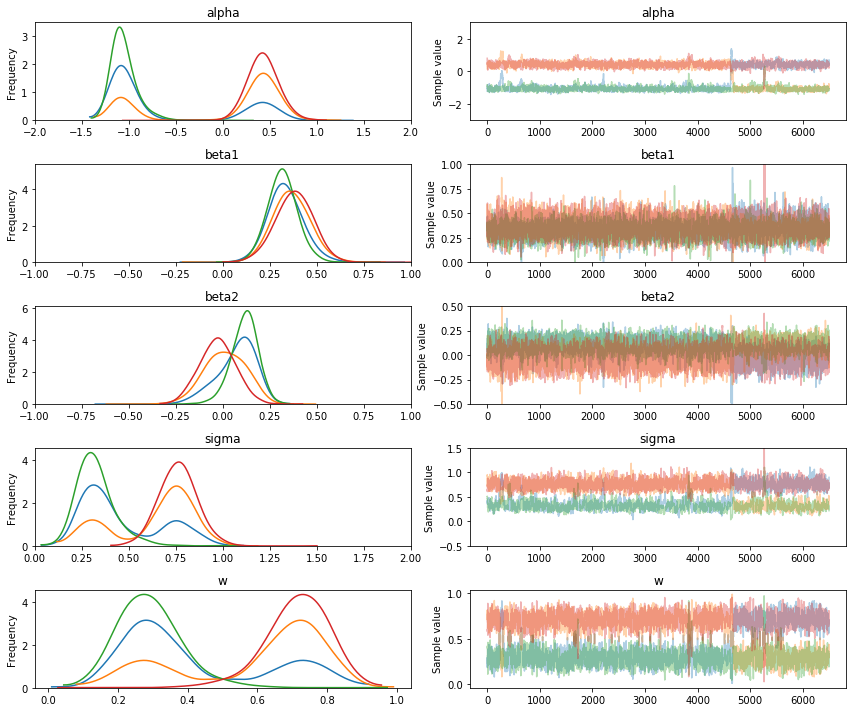

In [93]:
ax = pm.traceplot(trace2c[1500:8000])
ax[0,0].set_xlim(-2,2)
ax[0,1].set_ylim(-3,3)
ax[1,0].set_xlim(-1,1)
ax[1,1].set_ylim(-0,1)
ax[2,0].set_xlim(-1,1)
ax[2,1].set_ylim(-.5,.5)
ax[3,0].set_xlim(0,2)
ax[3,1].set_ylim(-.5,1.5)
plt.savefig('Mixture_Component_Results.png')

Zooming in from 0 -> 4500, things look like they're in 1 mode. I'll use this section for analysis.

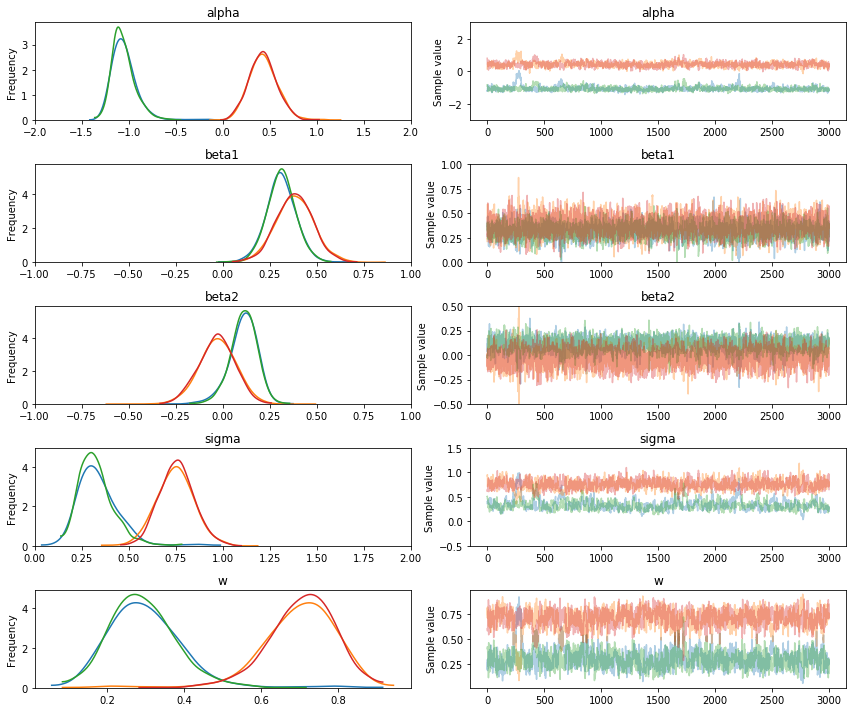

In [94]:
ax = pm.traceplot(trace2c[1500:4500])
ax[0,0].set_xlim(-2,2)
ax[0,1].set_ylim(-3,3)
ax[1,0].set_xlim(-1,1)
ax[1,1].set_ylim(-0,1)
ax[2,0].set_xlim(-1,1)
ax[2,1].set_ylim(-.5,.5)
ax[3,0].set_xlim(0,2)
ax[3,1].set_ylim(-.5,1.5)
plt.savefig('Mixture_Component_Results_zoom.png')

#### ACF/Thinning:

Text(0.5, 1.0, 'alpha')

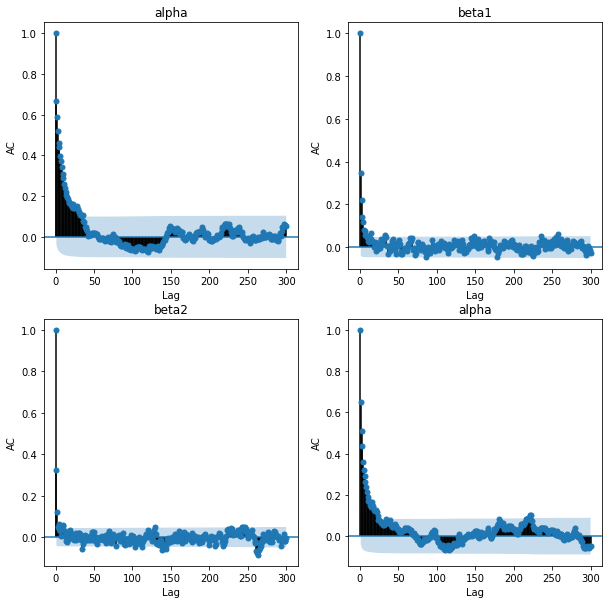

In [422]:
# make sure to only look at 1 mode, or else you'll have huge ACFs!
fig, ax = plt.subplots(2,2, figsize = (10,10))

max_lag=300

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2c['alpha'])[0][2000:4500], ax = ax[0,0], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[0,0].set_ylabel('AC')
ax[0,0].set_xlabel('Lag')
ax[0,0].set_title('alpha')

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2c['beta1'])[0][2000:4500], ax = ax[0,1], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[0,1].set_ylabel('AC')
ax[0,1].set_xlabel('Lag')
ax[0,1].set_title('beta1')

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2c['beta2'])[1][2000:4500], ax = ax[1,0], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[1,0].set_ylabel('AC')
ax[1,0].set_xlabel('Lag')
ax[1,0].set_title('beta2')

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2c['alpha'])[1][2000:4500], ax = ax[1,1], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[1,1].set_ylabel('AC')
ax[1,1].set_xlabel('Lag')
ax[1,1].set_title('alpha')

#plt.savefig('Mixture_ACF.png')

#### Convergence tests:

In [423]:
pm.diagnostics.gelman_rubin(trace2c[2000:4500][::50])

{'alpha': array([ 1.00212428,  1.00324752]),
 'beta1': array([ 1.01630567,  0.99141234]),
 'beta2': array([ 0.99033096,  0.99003617]),
 'sigma': array([ 1.01335003,  1.02692566]),
 'w': array([ 1.01281834,  1.01281834])}

#### Summary statistics:

In [424]:
pm.summary(trace2c[2000:4500][::50])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,-1.057298,0.126374,0.012213,-1.243067,-0.801440,83.408366,1.002124
alpha__1,0.422976,0.128863,0.012819,0.172917,0.682098,85.346073,1.003248
beta1__0,0.311831,0.082318,0.008534,0.123356,0.458478,88.929680,1.016306
beta1__1,0.389379,0.104105,0.010879,0.191139,0.597903,79.561823,0.991412
beta2__0,0.100036,0.069817,0.006905,-0.064264,0.208469,99.692973,0.990331
beta2__1,-0.022581,0.090700,0.009663,-0.185608,0.133382,71.363165,0.990036
sigma__0,0.337810,0.096151,0.009582,0.188879,0.536149,76.246501,1.013350
sigma__1,0.754773,0.084663,0.009060,0.605529,0.920019,88.987381,1.026926
w__0,0.290444,0.085955,0.008618,0.137746,0.455108,92.983220,1.012818
w__1,0.709556,0.085955,0.008618,0.544892,0.862254,92.983220,1.012818


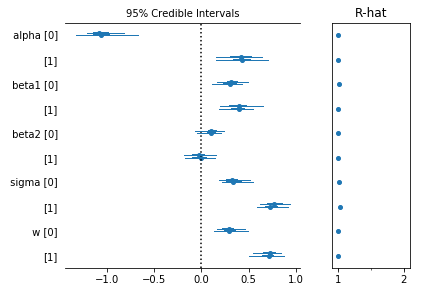

In [155]:
pm.forestplot(trace2c[1500:4500][::50]);
plt.savefig('Mixture_ParamResultsb.png')

#### Goodness of fit: simulating the posterior predictive

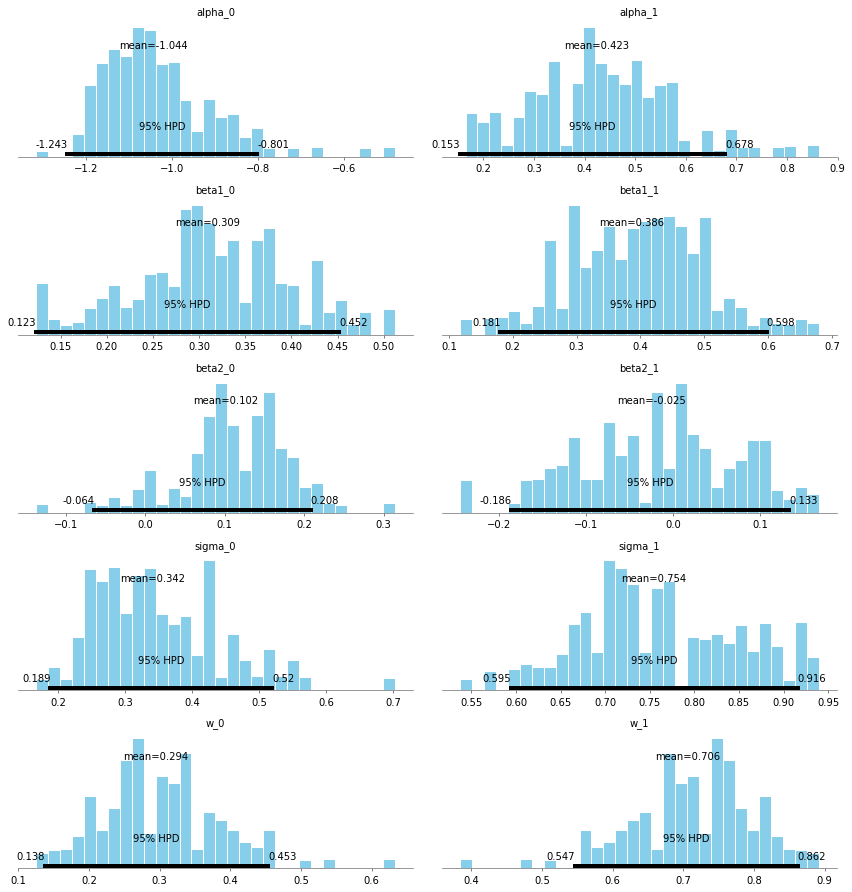

In [134]:
trace_approx = pm.Empirical(trace2c[1500:4500][::50], model=mixture_model_c)
pm.plot_posterior(trace_approx.sample(5000));

In [431]:
with mixture_model_c:
    ppc_2chain_b = pm.sample_posterior_predictive(trace2c[2000:4500][::50], 50000)

100%|██████████| 50000/50000 [02:21<00:00, 352.71it/s]


In [435]:
with mixture_model_c:
    ppc_2chain_b = pm.sample_posterior_predictive(trace2c[2000:4500][::50], 5000)

100%|██████████| 5000/5000 [00:13<00:00, 373.30it/s]


In [90]:
with mixture_model_c:
    ppc_2chain = pm.sample_posterior_predictive(trace2c[1500:4500][::50], 5000)

100%|██████████| 5000/5000 [00:14<00:00, 340.17it/s]


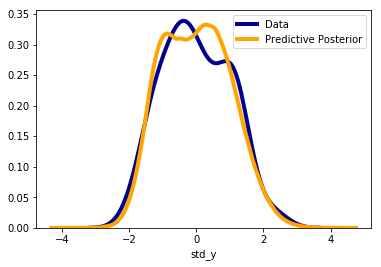

In [436]:
sns.distplot(Y, hist=False, kde=True, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label': 'Data'})

sns.distplot(np.transpose(ppc_2chain_b['y_obs']).flatten(), hist=False, kde=True, 
             bins=40, color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'label': 'Predictive Posterior'}, axlabel = None)

#plt.savefig('Mixture_histogram.png')

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


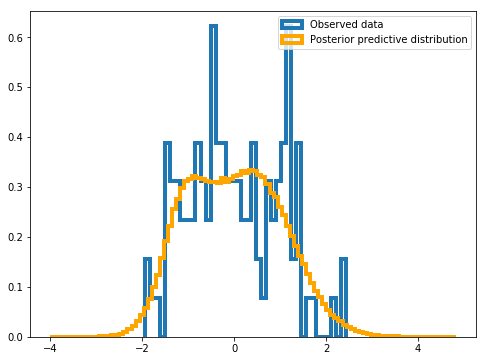

In [151]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(Y, bins=40, normed=True,
        histtype='step', lw=4,
        label='Observed data');
ax.hist(np.transpose(ppc_2chain['y_obs']).flatten(), color='orange', bins=100, normed=True,
        histtype='step', lw=4,
        label='Posterior predictive distribution');
#ax.hist(ppc['y_obs'].mean(axis=0), color = 'black', bins=30, normed=True,
#        histtype='step', lw=2, alpha = 1.0,
#        label='Posterior predictive distribution');

ax.legend(loc=1);
plt.savefig('Mixture_histogram.png')

In [ ]:
with mixture_model:
    
    ppc_2chain_b = pm.sample_posterior_predictive(trace2c[2000:4500][::50], 50000)

#### Model comparison:

In [153]:
df_comp=pm.compare({basic_model: trace[::10], mixture_model_c: trace2c[1500:4500][::50]})
df_comp
#indicates mixture is a better fit

/usr/local/lib/python3.5/dist-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
1,314.41,7.82,0,0.72,9.55,0,1
0,321.35,4.22,6.94,0.28,11.26,7.91,0


### Resampling:

We picked priors $\alpha, \beta1, \beta2 \sim Cauchy(0, 1.25)$, $\sigma \sim HalfCauchy(1)$. We will try to change the mean and variance of these priors and via importance sampling back out how sensitive our results are to it.

First change $\alpha[0] \sim Cauchy(1, 2.5) , \alpha[1] \sim Cauchy(-.5, 2.5)$

In [162]:
np.transposetrace2c['alpha']

array([[-0.15711835,  0.93922523],
       [-0.19638952,  0.80661448],
       [-0.00390487,  0.8753796 ],
       ..., 
       [ 0.29724174, -0.05690098],
       [ 0.34916698, -0.0282103 ],
       [ 0.46638937, -0.11618273]])

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


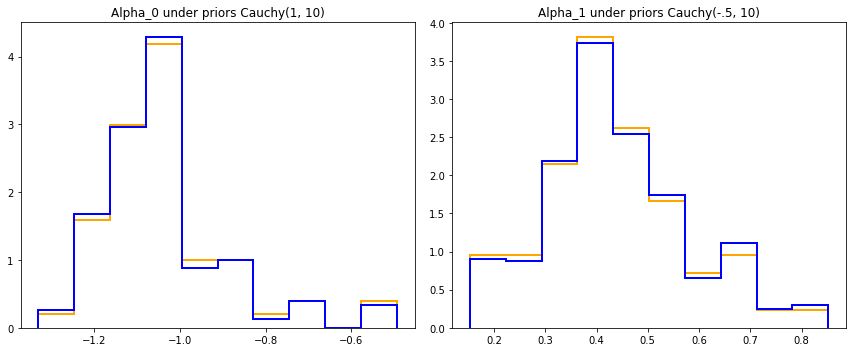

In [175]:
def weights(alpha0, alpha1):
    prior1 = stats.cauchy.pdf(alpha0,0,1.25)*stats.cauchy.pdf(alpha1, 0, 1.25)
    priornew = stats.cauchy.pdf(alpha0, 1, 10)*stats.cauchy.pdf(alpha1,-0.5,10)
    w = priornew/prior1
    return w

w = weights(np.transpose(trace2c['alpha'])[0][1500:4500][::50], np.transpose(trace2c['alpha'])[1][1500:4500][::50])
w = w/sum(w)
resample_t = np.random.choice(np.transpose(trace2c['alpha'])[0][1500:4500][::50], size = 2000, replace=True, p=w)
resample_t2 = np.random.choice(np.transpose(trace2c['alpha'])[1][1500:4500][::50], size = 2000, replace=True, p=w)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].hist(np.transpose(trace2c['alpha'])[0][1500:4500][::50], lw = 2, histtype = 'step', normed=True, color = 'orange')
ax[0].hist(resample_t, lw = 2, histtype = 'step', color = 'blue', normed=True)
ax[0].set_title('Alpha_0 under priors Cauchy(1, 10)')

ax[1].hist(np.transpose(trace2c['alpha'])[1][1500:4500][::50], lw = 2, histtype = 'step', normed=True, color = 'orange')
ax[1].hist(resample_t2, lw = 2, histtype = 'step', color = 'blue', normed=True)
ax[1].set_title('Alpha_1 under priors Cauchy(-.5, 10)')

plt.tight_layout()
plt.savefig('ImportanceSampling.png')

### Regression:

In [457]:
trace2c[1500:4500][::50]['alpha']

array([-1.20724706,  0.15297359])

In [460]:
# source: https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
def UnStandardize(intercept, slopes, sigma, or_Y, or_xs):
    '''
    takes the trace results for the intercept and slopes of an MCMC algorithm using standardized data, as well
    as the original unstandardized data (output or_Y, inputs or_xs), and returns the scaled results upon which
    means, standard deviations, and HPDs can be calculated.
    Assumes regression is Y ~ N(mu, sigma^2)
    '''
    suma = [slopes[i]*or_Y.std()/or_xs[i].std()*or_xs[i].mean() for i in range(len(or_xs))]
    intercept_orig = intercept*or_Y.std() + or_Y.mean() - sum(suma, axis=0)
    slopes_orig = [slopes[i]*or_Y.std()/or_xs[i].std() for i in range(len(or_xs))]
    sigma_orig = sigma*or_Y.std()
    
    return np.array(sigma_orig), np.array(intercept_orig), np.array(slopes_orig)

intercept_mixture_0 = np.transpose(trace2c[1500:4500][::50]['alpha'])[0]
intercept_mixture_1 = np.transpose(trace2c[1500:4500][::50]['alpha'])[1]
slope_var1_mixture_0 = np.transpose(trace2c[1500:4500][::50]['beta1'])[0]
slope_var1_mixture_1 = np.transpose(trace2c[1500:4500][::50]['beta1'])[1]
slope_var2_mixture_0 = np.transpose(trace2c[1500:4500][::50]['beta2'])[0]
slope_var2_mixture_1 = np.transpose(trace2c[1500:4500][::50]['beta2'])[1]
sigma_mixture_0 = np.transpose(trace2c[1500:4500][::50]['sigma'])[0]
sigma_mixture_1 = np.transpose(trace2c[1500:4500][::50]['sigma'])[1]
w_0 = np.transpose(trace2c[1500:4500][::50]['w'])[0]
w_1 = np.transpose(trace2c[1500:4500][::50]['w'])[1]

sigma_orig_0, int_orig_0, slopes_orig_0 = UnStandardize(intercept_mixture_0, np.array([slope_var1_mixture_0, slope_var2_mixture_0]), sigma_mixture_0, df['Y'], np.array([df['var1'],df['var2']]))
sigma_orig_1, int_orig_1, slopes_orig_1 = UnStandardize(intercept_mixture_1, np.array([slope_var1_mixture_1, slope_var2_mixture_1]), sigma_mixture_1, df['Y'], np.array([df['var1'],df['var2']]))

means = [int_orig_0.mean(), int_orig_1.mean(), slopes_orig_0[0].mean(),slopes_orig_1[0].mean(), slopes_orig_0[1].mean(),slopes_orig_1[1].mean(), sigma_orig_0.mean(),sigma_orig_1.mean(), w_0.mean(), w_1.mean()]
stds = [int_orig_0.std(), int_orig_1.std(), slopes_orig_0[0].std(),slopes_orig_1[0].std(), slopes_orig_0[1].std(),slopes_orig_1[1].std(), sigma_orig_0.std(),sigma_orig_1.std(), w_0.std(), w_1.std()]
hpds_l = [pm.stats.hpd(int_orig_0)[0], pm.stats.hpd(int_orig_1)[0], pm.stats.hpd(slopes_orig_0[0])[0],pm.stats.hpd(slopes_orig_1[0])[0], pm.stats.hpd(slopes_orig_0[1])[0],pm.stats.hpd(slopes_orig_1[1])[0], pm.stats.hpd(sigma_orig_0)[0],pm.stats.hpd(sigma_orig_1)[0], pm.stats.hpd(w_0)[0], pm.stats.hpd(w_1)[0]]
hpds_h = [pm.stats.hpd(int_orig_0)[1], pm.stats.hpd(int_orig_1)[1], pm.stats.hpd(slopes_orig_0[0])[1],pm.stats.hpd(slopes_orig_1[0])[1], pm.stats.hpd(slopes_orig_0[1])[1],pm.stats.hpd(slopes_orig_1[1])[1], pm.stats.hpd(sigma_orig_0)[1],pm.stats.hpd(sigma_orig_1)[1], pm.stats.hpd(w_0)[1], pm.stats.hpd(w_1)[1]]

data = {'mean': means, 'std': stds, 'hpd_2.5': hpds_l, 'hpd_97.5': hpds_h}
trace_unst_mix = pd.DataFrame(data=data, columns = ['mean', 'std', 'hpd_2.5', 'hpd_97.5'], index = ['alpha_0', 'alpha_1', 'beta1_0', 'beta1_1', 'beta2_0', 'beta2_1', 'sigma_0', 'sigma_1', 'w_0', 'w_1'])
trace_unst_mix

,mean,std,hpd_2.5,hpd_97.5
alpha_0,5.652010,2.936265,-0.217117,10.858255
alpha_1,11.800758,3.024498,5.958777,17.539670
beta1_0,1.838873,0.506910,0.692842,2.685940
beta1_1,2.306538,0.627406,1.074863,3.554929
beta2_0,0.582160,0.403917,-0.367678,1.192723
beta2_1,-0.146399,0.523715,-1.011076,0.856404
sigma_0,1.972372,0.551281,1.096370,3.096733
sigma_1,4.353862,0.529155,3.497462,5.390782
w_0,0.293829,0.086361,0.137746,0.455108
w_1,0.706171,0.086361,0.544892,0.862254


In [182]:
pm.summary(trace2c[1500:4500][::50])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,-1.044230,0.135105,0.012531,-1.243067,-0.774656,88.860977,0.996363
alpha__1,0.425248,0.141405,0.013149,0.152974,0.682098,107.468759,0.997563
beta1__0,0.309280,0.085257,0.008371,0.116529,0.451748,91.860511,1.010775
beta1__1,0.387936,0.105523,0.009561,0.180781,0.597903,108.063789,0.991679
beta2__0,0.101752,0.070598,0.006315,-0.064264,0.208469,117.035943,0.994185
beta2__1,-0.025588,0.091537,0.008729,-0.176720,0.149686,87.323028,0.991643
sigma__0,0.341484,0.095445,0.008794,0.189819,0.536149,106.003373,1.005609
sigma__1,0.753801,0.091615,0.009080,0.605529,0.933327,96.228446,1.025856
w__0,0.293829,0.086361,0.008175,0.137746,0.455108,116.636161,0.999436
w__1,0.706171,0.086361,0.008175,0.544892,0.862254,116.636161,0.999436


In [220]:
pred_1_dist[0]

array([-0.14757244, -0.7803576 , -0.12599273,  0.60977619, -0.38040004,
       -0.47103768,  0.46960302, -0.3071767 , -0.19168742,  0.05347201,
       -0.1730485 ,  0.13794778, -0.13699903, -0.42739986, -1.22463409,
       -1.27833031, -0.11019076, -0.53640185, -1.40498916,  0.3105085 ,
       -0.21693208, -0.03185445,  1.69110349, -0.1881068 , -0.24246958,
       -1.02833763,  0.45199844, -0.9221653 , -0.41924924,  0.01066375,
       -0.3300359 ,  0.96708146,  0.46201046, -0.18359118,  1.04435074,
       -0.06277779,  0.64909931, -0.02547683,  0.19966753,  1.14436242,
        0.53723959, -0.40442786, -0.99388505, -0.13735992,  0.27539835,
       -0.46200607, -0.81851414,  0.3118325 , -1.96690287, -0.54720226,
        0.89872763,  0.82794382,  0.06795218,  0.41350426, -1.10473415,
        0.18202604, -0.56877805,  0.09969937, -1.02125545,  0.17825114,
        0.11137465, -0.09620005, -0.92384614, -0.78581415, -0.15770905,
        0.09733623, -1.10998909, -0.79519431,  1.05346194, -0.46

In [318]:
tr = trace2c[1500:4500][::50]
def sample_posterior_x1_nosigma(x): # returns a random sample from the posterior for y(x1)
    alpha0_mean, alpha0_std = np.transpose(tr['alpha'])[0].mean(), np.transpose(tr['alpha'])[0].std()
    beta10_mean, beta10_std = np.transpose(tr['beta1'])[0].mean(), np.transpose(tr['beta1'])[0].std()
    w0_mean, w0_std = np.transpose(tr['w'])[0].mean(), np.transpose(tr['w'])[0].std()
    sigma0_mean, sigma0_std = np.transpose(tr['sigma'])[0].mean(), np.transpose(tr['sigma'])[0].std()
    
    # sample parameters randomly based on trace distribution
    alpha0_sample = np.random.normal(alpha0_mean, alpha0_std)
    beta10_sample = np.random.normal(beta10_mean, beta10_std)
    w0_sample = np.random.normal(w0_mean, w0_std)
    sigma0_sample = np.abs(np.random.normal(sigma0_mean, sigma0_std))
    
    
    # repeat for comp2
    alpha1_mean, alpha1_std = np.transpose(tr['alpha'])[1].mean(), np.transpose(tr['alpha'])[1].std()
    beta11_mean, beta11_std = np.transpose(tr['beta1'])[1].mean(), np.transpose(tr['beta1'])[1].std()
    sigma1_mean, sigma1_std = np.transpose(tr['sigma'])[1].mean(), np.transpose(tr['sigma'])[1].std()
    
    alpha1_sample = np.random.normal(alpha1_mean, alpha1_std)
    beta11_sample = np.random.normal(beta11_mean, beta11_std)
    w1_sample = 1- w0_sample
    sigma1_sample = np.abs(np.random.normal(sigma1_mean, sigma1_std))

 #   for i in X1: # for each Xi, randomly choose with weight w if point comes from distribution 1 or 2
    rand_no = np.random.rand()
    if rand_no <= w0_sample:
        out = alpha0_sample + beta10_sample*x
    else:
        out = alpha1_sample + beta11_sample*x
    
    return out

def sample_posterior_x1(x): # returns a random sample from the posterior for y(x1)
    alpha0_mean, alpha0_std = np.transpose(tr['alpha'])[0].mean(), np.transpose(tr['alpha'])[0].std()
    beta10_mean, beta10_std = np.transpose(tr['beta1'])[0].mean(), np.transpose(tr['beta1'])[0].std()
    w0_mean, w0_std = np.transpose(tr['w'])[0].mean(), np.transpose(tr['w'])[0].std()
    sigma0_mean, sigma0_std = np.transpose(tr['sigma'])[0].mean(), np.transpose(tr['sigma'])[0].std()
    
    # sample parameters randomly based on trace distribution
    alpha0_sample = np.random.normal(alpha0_mean, alpha0_std)
    beta10_sample = np.random.normal(beta10_mean, beta10_std)
    w0_sample = np.random.normal(w0_mean, w0_std)
    sigma0_sample = np.abs(np.random.normal(sigma0_mean, sigma0_std))
    
    
    # repeat for comp2
    alpha1_mean, alpha1_std = np.transpose(tr['alpha'])[1].mean(), np.transpose(tr['alpha'])[1].std()
    beta11_mean, beta11_std = np.transpose(tr['beta1'])[1].mean(), np.transpose(tr['beta1'])[1].std()
    sigma1_mean, sigma1_std = np.transpose(tr['sigma'])[1].mean(), np.transpose(tr['sigma'])[1].std()
    
    alpha1_sample = np.random.normal(alpha1_mean, alpha1_std)
    beta11_sample = np.random.normal(beta11_mean, beta11_std)
    w1_sample = 1- w0_sample
    sigma1_sample = np.abs(np.random.normal(sigma1_mean, sigma1_std))

 #   for i in X1: # for each Xi, randomly choose with weight w if point comes from distribution 1 or 2
    rand_no = np.random.rand()
    if rand_no <= w0_sample:
        out = np.random.normal(alpha0_sample + beta10_sample*x, sigma0_sample)
    else:
        out = np.random.normal(alpha1_sample + beta11_sample*x, sigma1_sample)
    
    return out

pred_comp1 = (np.transpose(tr['alpha'])[0].mean() + np.transpose(tr['beta1'])[0].mean()*X1)
pred_comp2 = (np.transpose(tr['alpha'])[1].mean() + np.transpose(tr['beta1'])[1].mean()*X1)
pred_1 = np.transpose(tr['w'])[0].mean()*pred_comp1 + np.transpose(tr['w'])[1].mean()*pred_comp2
pred_1_dist = [ [sample_posterior_x1(i) for i in xs] for j in range(20) ]
xs = np.linspace(-2.5,2.5, 50)
pred_1_dist_nosigma = [ [sample_posterior_x1_nosigma(i) for i in xs] for j in range(20) ]


pred_comp1b = np.transpose(tr['w'])[0].mean()*(np.transpose(tr['alpha'])[0].mean() + np.transpose(tr['beta1'])[0].mean()*X2)
pred_comp2b = np.transpose(tr['w'])[1].mean()*(np.transpose(tr['alpha'])[1].mean() + np.transpose(tr['beta1'])[1].mean()*X2)

20


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


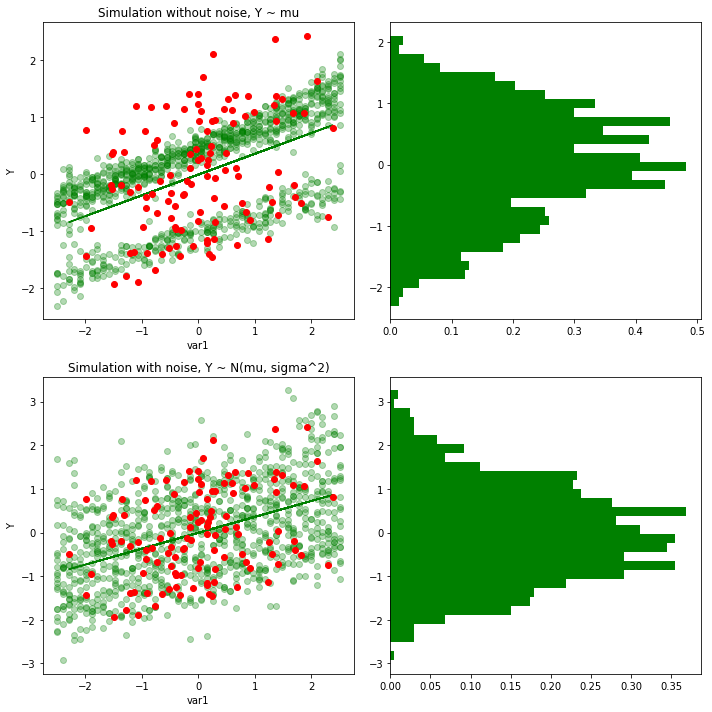

In [319]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].plot(X1, pred_1, 'g-', label = 'Average regression')
ax[1,0].plot(X1, pred_1, 'g-', label = 'Average regression')
i = 0
print(len(pred_1_dist))
for i in range(len(pred_1_dist)):
        ax[0,0].plot(xs, pred_1_dist_nosigma[i], 'go', alpha = .3, label = 'Simulation')
        i +=1
ax[0,0].plot(X1, Y, 'ro', label = 'Data')
ax[0,0].set_xlabel('var1')
ax[0,0].set_ylabel('Y')

ax[0,1].hist(np.array(pred_1_dist_nosigma).flatten(), orientation = 'horizontal', color = 'green', bins = 30, lw = 3, normed = True)

for i in range(len(pred_1_dist)):
        ax[1,0].plot(xs, pred_1_dist[i], 'go', alpha = .3)
        i +=1
ax[1,0].plot(X1, Y, 'ro')
ax[1,0].set_xlabel('var1')
ax[1,0].set_ylabel('Y')

ax[1,1].hist(np.array(pred_1_dist).flatten(), orientation = 'horizontal', color = 'green', bins = 30, lw = 3, normed = True)
ax[0,0].set_title('Simulation without noise, Y ~ mu')
ax[1,0].set_title('Simulation with noise, Y ~ N(mu, sigma^2)')

plt.tight_layout()
plt.savefig('Var1_Simulationresults.png')

In [320]:
tr = trace2c[1500:4500][::50]
def sample_posterior_x2_nosigma(x): # returns a random sample from the posterior for y(x1)
    alpha0_mean, alpha0_std = np.transpose(tr['alpha'])[0].mean(), np.transpose(tr['alpha'])[0].std()
    beta20_mean, beta20_std = np.transpose(tr['beta2'])[0].mean(), np.transpose(tr['beta2'])[0].std()
    w0_mean, w0_std = np.transpose(tr['w'])[0].mean(), np.transpose(tr['w'])[0].std()
    sigma0_mean, sigma0_std = np.transpose(tr['sigma'])[0].mean(), np.transpose(tr['sigma'])[0].std()
    
    # sample parameters randomly based on trace distribution
    alpha0_sample = np.random.normal(alpha0_mean, alpha0_std)
    beta20_sample = np.random.normal(beta20_mean, beta20_std)
    w0_sample = np.random.normal(w0_mean, w0_std)
    sigma0_sample = np.abs(np.random.normal(sigma0_mean, sigma0_std))
    
    
    # repeat for comp2
    alpha1_mean, alpha1_std = np.transpose(tr['alpha'])[1].mean(), np.transpose(tr['alpha'])[1].std()
    beta21_mean, beta21_std = np.transpose(tr['beta2'])[1].mean(), np.transpose(tr['beta2'])[1].std()
    sigma1_mean, sigma1_std = np.transpose(tr['sigma'])[1].mean(), np.transpose(tr['sigma'])[1].std()
    
    alpha1_sample = np.random.normal(alpha1_mean, alpha1_std)
    beta21_sample = np.random.normal(beta21_mean, beta21_std)
    w1_sample = 1- w0_sample
    sigma1_sample = np.abs(np.random.normal(sigma1_mean, sigma1_std))

 #   for i in X1: # for each Xi, randomly choose with weight w if point comes from distribution 1 or 2
    rand_no = np.random.rand()
    if rand_no <= w0_sample:
        out = alpha0_sample + beta20_sample*x
    else:
        out = alpha1_sample + beta21_sample*x
    
    return out

def sample_posterior_x2(x): # returns a random sample from the posterior for y(x1)
    alpha0_mean, alpha0_std = np.transpose(tr['alpha'])[0].mean(), np.transpose(tr['alpha'])[0].std()
    beta20_mean, beta20_std = np.transpose(tr['beta2'])[0].mean(), np.transpose(tr['beta2'])[0].std()
    w0_mean, w0_std = np.transpose(tr['w'])[0].mean(), np.transpose(tr['w'])[0].std()
    sigma0_mean, sigma0_std = np.transpose(tr['sigma'])[0].mean(), np.transpose(tr['sigma'])[0].std()
    
    # sample parameters randomly based on trace distribution
    alpha0_sample = np.random.normal(alpha0_mean, alpha0_std)
    beta20_sample = np.random.normal(beta20_mean, beta20_std)
    w0_sample = np.random.normal(w0_mean, w0_std)
    sigma0_sample = np.abs(np.random.normal(sigma0_mean, sigma0_std))
    
    
    # repeat for comp2
    alpha1_mean, alpha1_std = np.transpose(tr['alpha'])[1].mean(), np.transpose(tr['alpha'])[1].std()
    beta21_mean, beta21_std = np.transpose(tr['beta2'])[1].mean(), np.transpose(tr['beta2'])[1].std()
    sigma1_mean, sigma1_std = np.transpose(tr['sigma'])[1].mean(), np.transpose(tr['sigma'])[1].std()
    
    alpha1_sample = np.random.normal(alpha1_mean, alpha1_std)
    beta21_sample = np.random.normal(beta21_mean, beta21_std)
    w1_sample = 1- w0_sample
    sigma1_sample = np.abs(np.random.normal(sigma1_mean, sigma1_std))

 #   for i in X1: # for each Xi, randomly choose with weight w if point comes from distribution 1 or 2
    rand_no = np.random.rand()
    if rand_no <= w0_sample:
        out = np.random.normal(alpha0_sample + beta20_sample*x, sigma0_sample)
    else:
        out = np.random.normal(alpha1_sample + beta21_sample*x, sigma1_sample)
    
    return out

pred_comp1 = (np.transpose(tr['alpha'])[0].mean() + np.transpose(tr['beta1'])[0].mean()*X1)
pred_comp2 = (np.transpose(tr['alpha'])[1].mean() + np.transpose(tr['beta1'])[1].mean()*X1)
pred_1 = np.transpose(tr['w'])[0].mean()*pred_comp1 + np.transpose(tr['w'])[1].mean()*pred_comp2
pred_1_dist = [ [sample_posterior_x1(i) for i in xs] for j in range(20) ]
xs = np.linspace(-2.5,2.5, 50)
pred_1_dist_nosigma = [ [sample_posterior_x1_nosigma(i) for i in xs] for j in range(20) ]


pred_comp1b = np.transpose(tr['w'])[0].mean()*(np.transpose(tr['alpha'])[0].mean() + np.transpose(tr['beta2'])[0].mean()*X2)
pred_comp2b = np.transpose(tr['w'])[1].mean()*(np.transpose(tr['alpha'])[1].mean() + np.transpose(tr['beta2'])[1].mean()*X2)
pred_2 = np.transpose(tr['w'])[0].mean()*pred_comp1b + np.transpose(tr['w'])[1].mean()*pred_comp2b
xs = np.linspace(-2.5,2.5, 50)
pred_2_dist = [ [sample_posterior_x2(i) for i in xs] for j in range(20) ]
pred_2_dist_nosigma = [ [sample_posterior_x2_nosigma(i) for i in xs] for j in range(20) ]


20


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


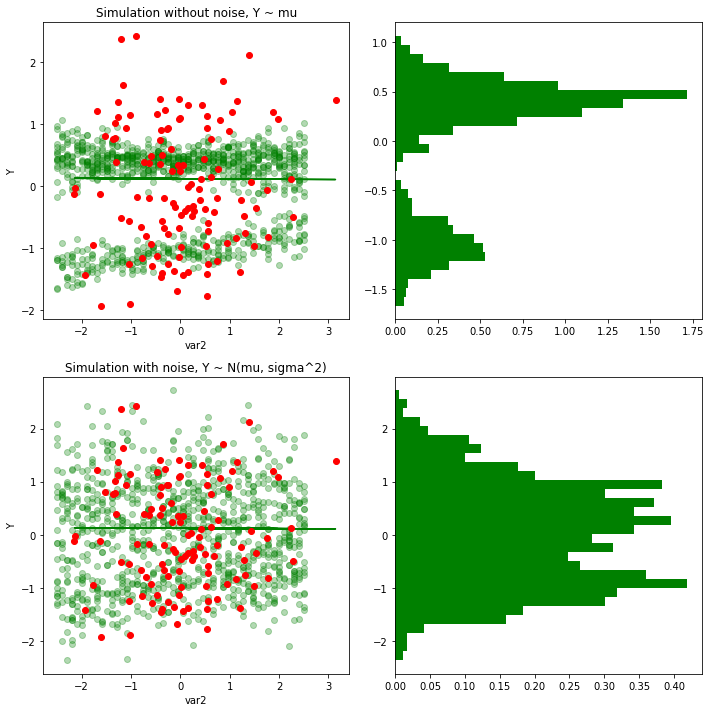

In [321]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].plot(X2, pred_2, 'g-', label = 'Average regression')
ax[1,0].plot(X2, pred_2, 'g-', label = 'Average regression')
i = 0
print(len(pred_2_dist))
for i in range(len(pred_2_dist)):
        ax[0,0].plot(xs, pred_2_dist_nosigma[i], 'go', alpha = .3, label = 'Simulation')
        i +=1
ax[0,0].plot(X2, Y, 'ro', label = 'Data')
ax[0,0].set_xlabel('var2')
ax[0,0].set_ylabel('Y')

ax[0,1].hist(np.array(pred_2_dist_nosigma).flatten(), orientation = 'horizontal', color = 'green', bins = 30, lw = 3, normed=True)

for i in range(len(pred_2_dist)):
        ax[1,0].plot(xs, pred_2_dist[i], 'go', alpha = .3)
        i +=1
ax[1,0].plot(X2, Y, 'ro')
ax[1,0].set_xlabel('var2')
ax[1,0].set_ylabel('Y')

ax[1,1].hist(np.array(pred_2_dist).flatten(), orientation = 'horizontal', color = 'green', bins = 30, lw = 3, normed=True)
ax[0,0].set_title('Simulation without noise, Y ~ mu')
ax[1,0].set_title('Simulation with noise, Y ~ N(mu, sigma^2)')

plt.tight_layout()
plt.savefig('Var2_Simulationresults.png')

In [ ]:
regressions = ppc_2chain['alpha']

## Just intercepts:

In [141]:
from pymc3 import Model, Normal, HalfNormal, Beta
from theano import tensor as tt




with pm.Model() as intercept_model:
    # Priors
    alpha = pm.Cauchy('alpha', alpha=0, beta=1.2, shape=2)
    sigma = pm.HalfCauchy('sigma', beta=1.0, shape = 2)
    
    # Expected value of outcome
    mu = tt.stack([alpha[0], 
                   alpha[1]], axis = 1)
    
    order_means_potential = pm.Potential('order_means_potential', tt.switch(mu[0] - mu[1] < 0, -np.inf, 0))
    
    # weights
    w = pm.Dirichlet('w', np.array([1, 1]))

    y_obs = pm.NormalMixture('y_obs', w, mu, sd=sigma, comp_shape = (2,), observed=Y)
    
#    step = pm.Metropolis()
    trace_int = pm.sample(5000, init = 'advi_map', chains=2, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
/usr/local/lib/python3.5/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -171.88, ||grad|| = 2.1213: 100%|██████████| 6/6 [00:00<00:00, 456.50it/s]
Average Loss = inf:   5%|▌         | 10756/200000 [00:26<07:21, 428.61it/s]   
Convergence achieved at 10800
Interrupted at 10,799 [5%]: Average Loss = 187.52
Sequential sampling (2 chains in 1 job)
NUTS: [w, sigma, alpha]
100%|██████████| 5500/5500 [00:58<00:00, 94.25it/s] 
There were 537 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1041 divergences after tuning. Increase `target_accept` or reparameterize.
The number o

(-3, 3)

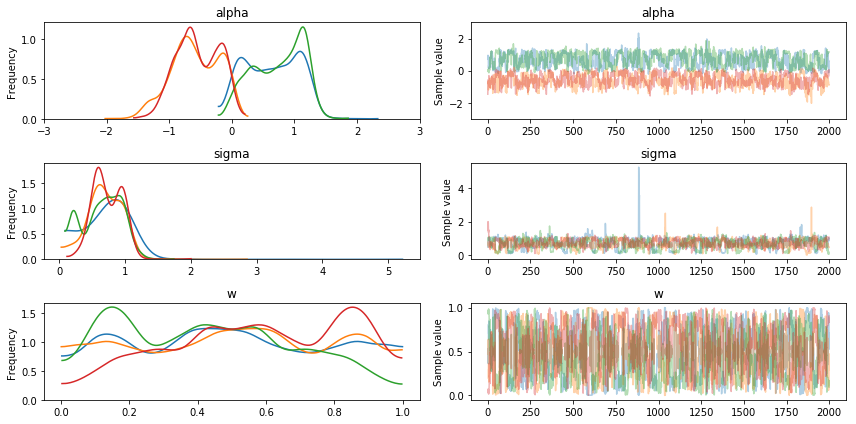

In [147]:
ax = pm.traceplot(trace_int[:2000])
ax[0,0].set_xlim(-3,3)
ax[0,1].set_ylim(-3,3)

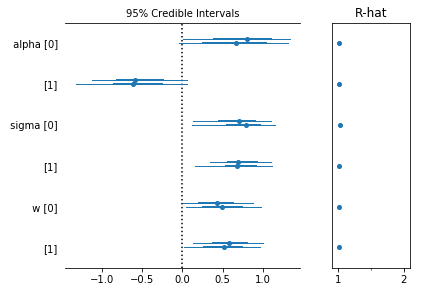

In [148]:
pm.forestplot(trace_int[:2000]);

## Trying a longer sample...

In [121]:
from pymc3 import Model, Normal, HalfNormal, Beta
from theano import tensor as tt




with pm.Model() as mixture_model_long:
    # Priors
    
 #   BoundedPrior = pm.Bound(pm.Cauchy, lower = -5, upper = 5)
 #   alpha_a = BoundedPrior('alpha_a', alpha=1.15, beta=2.5, shape = 2)
 #   alpha_b = BoundedPrior('alpha_b', alpha=-.5, beta=2.5, shape = 2)
 #   beta1 = BoundedPrior('beta1', alpha=0, beta=0.75, shape = 2)
 #   beta2 = BoundedPrior('beta2', alpha=0, beta=0.75, shape = 2)
#  beta3 = pm.Cauchy('beta3', alpha=0, beta=0.75, shape = 2)
#    BoundedNoise = pm.Bound(pm.HalfCauchy, lower = 0, upper = 4)
#    sigma = BoundedNoise('sigma', beta=0.75, shape = 2)
    
  #  alpha_a = pm.Cauchy('alpha_a', alpha=-0.5, beta=2.5, shape = 1)
  #  alpha_b = pm.Cauchy('alpha_b', alpha=1.15, beta=2.5, shape = 1)
    alpha = pm.Cauchy('alpha', alpha=0, beta=2.5, shape=2)
    beta1 = pm.Cauchy('beta1', alpha=0, beta=2.5, shape = 2)
    beta2 = pm.Cauchy('beta2', alpha=0, beta=2.5, shape = 2)
 #   beta3 = pm.Cauchy('beta3', alpha=0, beta=2.5, shape = 2)
    sigma = pm.HalfCauchy('sigma', beta=1.0, shape = 2)
    
    # Expected value of outcome
    mu = tt.stack([alpha[0] + beta1[0]*X1 + beta2[0]*X2, 
                   alpha[1] + beta1[1]*X1 + beta2[1]*X2], axis = 1)
    
    order_means_potential = pm.Potential('order_means_potential', tt.switch(mu[1] - mu[0] > 0, -np.inf, 0))
    
    # weights
#    BoundedWeights = pm.Bound(pm.Dirichlet, lower=0.1, upper = 0.9)
   # BoundedWeights = pm.Bound(pm.Beta, lower=0.1, upper = 0.9)
   # beta = BoundedWeights('beta', alpha = 7., beta = 3, shape = 2)
 #   w = np.array([beta, 1-beta])
    w = pm.Dirichlet('w', np.array([1, 1]))

    y_obs = pm.NormalMixture('y_obs', w, mu, sd=sigma, comp_shape = (2,), observed=Y)
    
#    step = pm.Metropolis()
#    data = {'alpha': [-1.2, .5], 'beta1': [.5,.5], 'beta2': [.25, -.25], 'sigma': [.2, .8]}
#    starting_point = dict(data)
    trace_l = pm.sample(4000, init = 'advi_map', chains=1, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
/usr/local/lib/python3.5/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -181.59, ||grad|| = 30.201: 100%|██████████| 9/9 [00:00<00:00, 542.73it/s]
Average Loss = inf:   5%|▌         | 10675/200000 [00:29<08:22, 376.89it/s]   
Convergence achieved at 10700
Interrupted at 10,699 [5%]: Average Loss = 193.7
Sequential sampling (1 chains in 1 job)
NUTS: [w, sigma, beta2, beta1, alpha]
100%|██████████| 10500/10500 [01:56<00:00, 90.33it/s] 
There were 333 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks

(-1, 1.5)

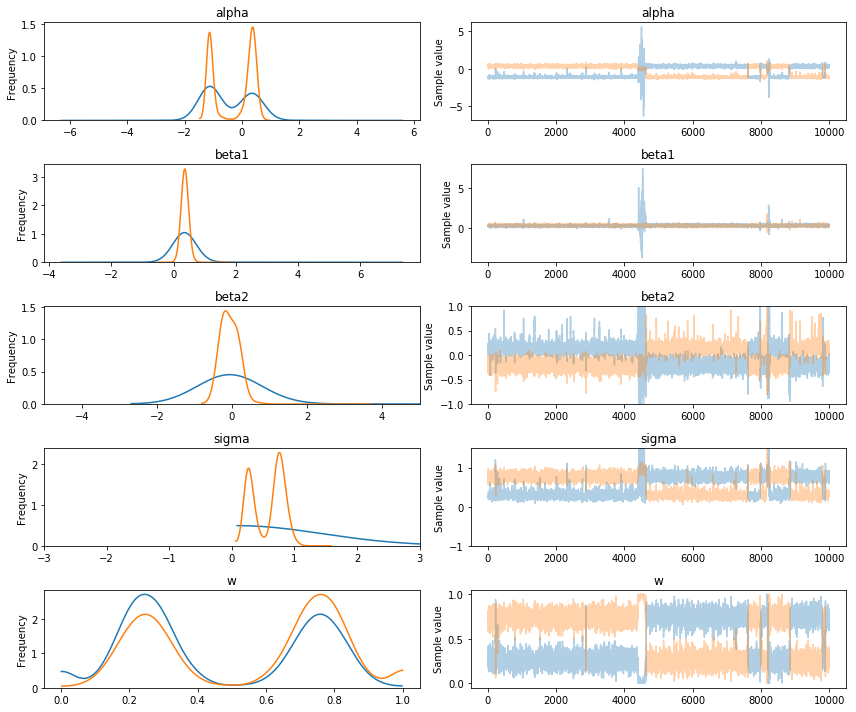

In [122]:
#fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,3))
ax = pm.traceplot(trace_l)
#ax[0,0].set_xlim(-5,5)
#ax[0,1].set_ylim(-3,3)
#ax[1,0].set_xlim(-3,3)
#ax[1,1].set_ylim(-.75,1.25)
ax[2,0].set_xlim(-5,5)
ax[2,1].set_ylim(-1,1)
ax[3,0].set_xlim(-3,3)
ax[3,1].set_ylim(-1,1.5)

## The nicest one:

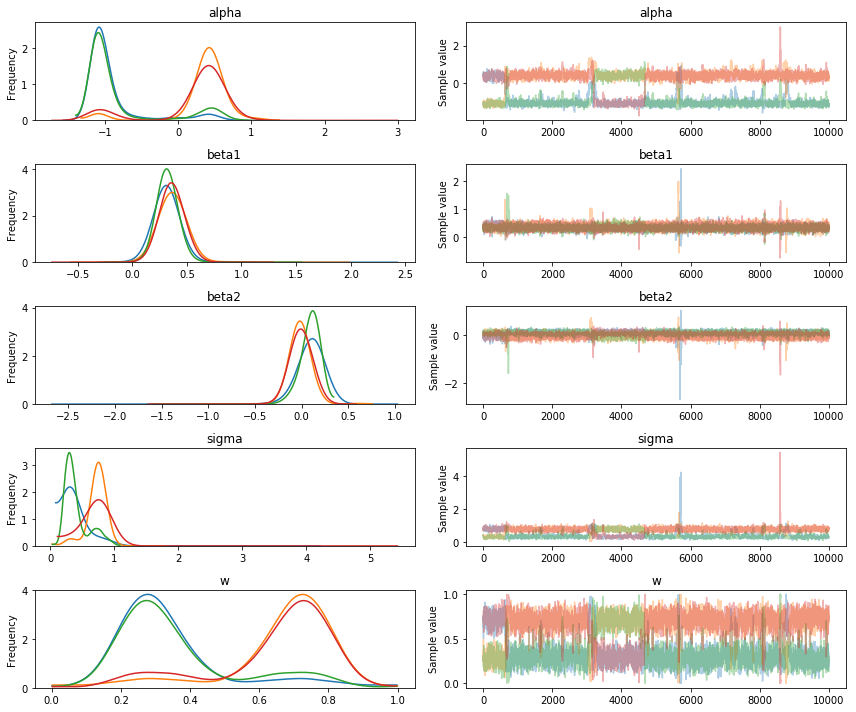

In [323]:
pm.traceplot(trace2)
plt.show()

Text(0.5, 1.0, 'alphab')

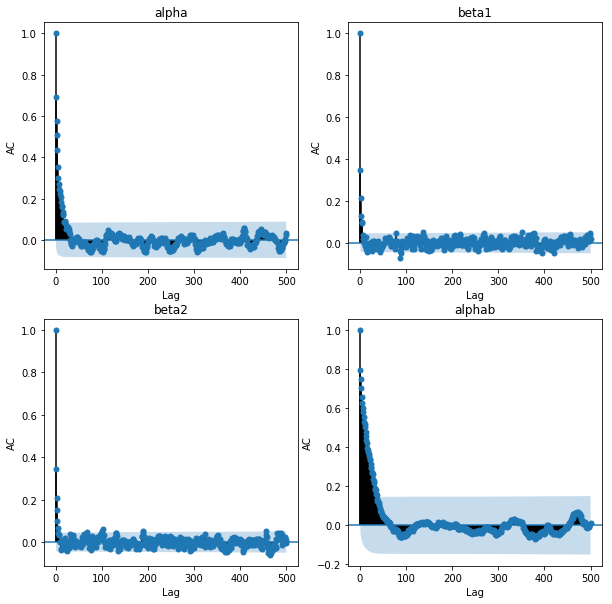

In [11]:
# make sure to only look at 1 mode, or else you'll have huge ACFs!
fig, ax = plt.subplots(2,2, figsize = (10,10))

max_lag=500

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2['alpha'])[0][300:3000], ax = ax[0,0], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[0,0].set_ylabel('AC')
ax[0,0].set_xlabel('Lag')
ax[0,0].set_title('alpha')

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2['beta1'])[0][300:3000], ax = ax[0,1], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[0,1].set_ylabel('AC')
ax[0,1].set_xlabel('Lag')
ax[0,1].set_title('beta1')

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2['beta2'])[1][300:3000], ax = ax[1,0], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[1,0].set_ylabel('AC')
ax[1,0].set_xlabel('Lag')
ax[1,0].set_title('beta2')

statsmodels.graphics.tsaplots.plot_acf(np.transpose(trace2['alpha'])[1][300:3000], ax = ax[1,1], use_vlines = True, lags = max_lag)
#    ax[2].acorr(samples, normed = True)
ax[1,1].set_ylabel('AC')
ax[1,1].set_xlabel('Lag')
ax[1,1].set_title('alphab')


In [12]:
with mixture_model_2comp:
    ppc = pm.sample_posterior_predictive(trace2[300:3000][::100], 5000)

100%|██████████| 5000/5000 [00:11<00:00, 420.02it/s]


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


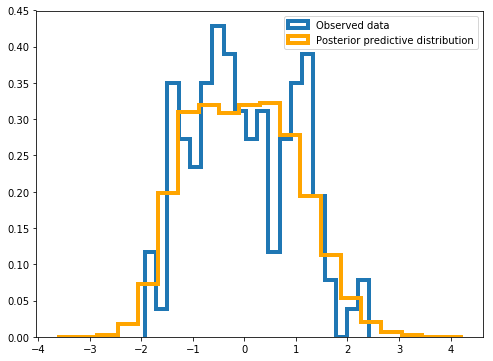

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(Y, bins=20, normed=True,
        histtype='step', lw=4,
        label='Observed data');
ax.hist(np.transpose(ppc['y_obs']).flatten(), color='orange', bins=20, normed=True,
        histtype='step', lw=4,
        label='Posterior predictive distribution');
#ax.hist(ppc['y_obs'].mean(axis=0), color = 'black', bins=30, normed=True,
#        histtype='step', lw=2, alpha = 1.0,
#        label='Posterior predictive distribution');

ax.legend(loc=1);

## More than 2 mixture components:

In [133]:
from pymc3 import Model, Normal, HalfNormal, Beta
from theano import tensor as tt

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

K = 2

with pm.Model() as mixture_model_Kcomp_b:
    # Priors
    alpha = pm.Cauchy('alpha', alpha=0, beta=1.25, shape = K)
    beta1 = pm.Cauchy('beta1', alpha=0, beta=0.75, shape = K)
    beta2 = pm.Cauchy('beta2', alpha=0, beta=0.75, shape = K)
  #  beta3 = pm.Cauchy('beta3', alpha=0, beta=0.75, shape = 2)
    sigma = pm.HalfCauchy('sigma', beta=0.75, shape = K)
    
    # Expected value of outcome
    mu = tt.stack([alpha[i] + beta1[i]*X1 + beta2[i]*X2 for i in range(0,K) ], axis = 1)    
   # order_means_potential = pm.Potential('order_means_potential', tt.switch(mu[1] - mu[0] < 0, -np.inf, 0) + tt.switch(mu[2] - mu[1] < 0, -np.inf, 0))
 #   order_means_potential2 = pm.Potential('order_means_potential_m2', tt.switch(mu[2] - mu[1] < 0, -np.inf, 0))
 #   order_means_potential3 = pm.Potential('order_means_potential_m3', tt.switch(mu[3] - mu[2] < 0, -np.inf, 0))
    
    # weights
 #   betadist = pm.Beta('betadist', 1.5, 1.5, shape=K)
 #   w = pm.Deterministic('w', stick_breaking(betadist))
    w = pm.Dirichlet('w', np.ones(K))

    y_obs = pm.NormalMixture('y_obs', w, mu, sd=sigma, comp_shape = (K,), observed=Y)
    
    traceK_b = pm.sample(10000, init = 'advi_map', chains=2, nuts_kwargs=dict(target_accept=.97))

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
/usr/local/lib/python3.5/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -186.37, ||grad|| = 79.501: 100%|██████████| 10/10 [00:00<00:00, 555.97it/s]
Average Loss = 178.61:   5%|▌         | 10491/200000 [00:25<12:23, 254.98it/s]
Convergence achieved at 10500
Interrupted at 10,499 [5%]: Average Loss = 194.18
Sequential sampling (2 chains in 1 job)
NUTS: [w, sigma, beta2, beta1, alpha]
100%|██████████| 10500/10500 [03:27<00:00, 65.96it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


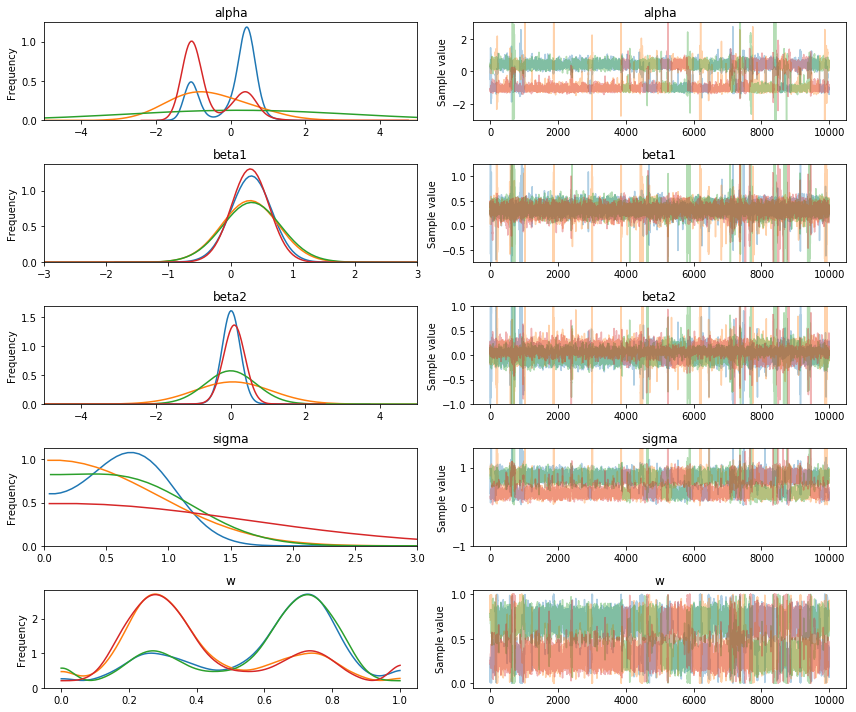

In [134]:
ax = pm.traceplot(traceK_b)
ax[0,0].set_xlim(-5,5)
ax[0,1].set_ylim(-3,3)
ax[1,0].set_xlim(-3,3)
ax[1,1].set_ylim(-.75,1.25)
ax[2,0].set_xlim(-5,5)
ax[2,1].set_ylim(-1,1)
ax[3,0].set_xlim(0,3)
ax[3,1].set_ylim(-1,1.5)
plt.show()

In [142]:
np.transpose(traceK_b['alpha'])[0]

array([-1.11452743, -0.99650788, -0.92894135, ...,  0.62542752,
        0.29926587,  0.27039415])

In [ ]:
def modedet(array):
    '''
    Takes trace of a pymc3 for a particular variable and returns the two solutions for it
    '''
    

## Something that works:

In [127]:
from pymc3 import Model, Normal, HalfNormal, Beta
from theano import tensor as tt

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

K = 2

with pm.Model() as mixture_model_Kcomp:
    # Priors
    alpha = pm.Cauchy('alpha', alpha=0, beta=1.25, shape = K)
    beta1 = pm.Cauchy('beta1', alpha=0, beta=0.75, shape = K)
    beta2 = pm.Cauchy('beta2', alpha=0, beta=0.75, shape = K)
  #  beta3 = pm.Cauchy('beta3', alpha=0, beta=0.75, shape = 2)
    sigma = pm.HalfCauchy('sigma', beta=0.75, shape = K)
    
    # Expected value of outcome
    mu = tt.stack([alpha[i] + beta1[i]*X1 + beta2[i]*X2 for i in range(0,K) ], axis = 1)    
   # order_means_potential = pm.Potential('order_means_potential', tt.switch(mu[1] - mu[0] < 0, -np.inf, 0) + tt.switch(mu[2] - mu[1] < 0, -np.inf, 0))
 #   order_means_potential2 = pm.Potential('order_means_potential_m2', tt.switch(mu[2] - mu[1] < 0, -np.inf, 0))
 #   order_means_potential3 = pm.Potential('order_means_potential_m3', tt.switch(mu[3] - mu[2] < 0, -np.inf, 0))
    
    # weights
 #   betadist = pm.Beta('betadist', 1.5, 1.5, shape=K)
 #   w = pm.Deterministic('w', stick_breaking(betadist))
    w = pm.Dirichlet('w', np.ones(K))

    y_obs = pm.NormalMixture('y_obs', w, mu, sd=sigma, comp_shape = (K,), observed=Y)
    
    traceK = pm.sample(10000, init = 'advi_map', chains=2, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
/usr/local/lib/python3.5/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -186.37, ||grad|| = 79.501: 100%|██████████| 10/10 [00:00<00:00, 641.92it/s]
Average Loss = 178.35:   5%|▌         | 10690/200000 [00:39<13:30, 233.69it/s]
Convergence achieved at 10700
Interrupted at 10,699 [5%]: Average Loss = 194.09
Sequential sampling (2 chains in 1 job)
NUTS: [w, sigma, beta2, beta1, alpha]
100%|██████████| 10500/10500 [02:49<00:00, 62.08it/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


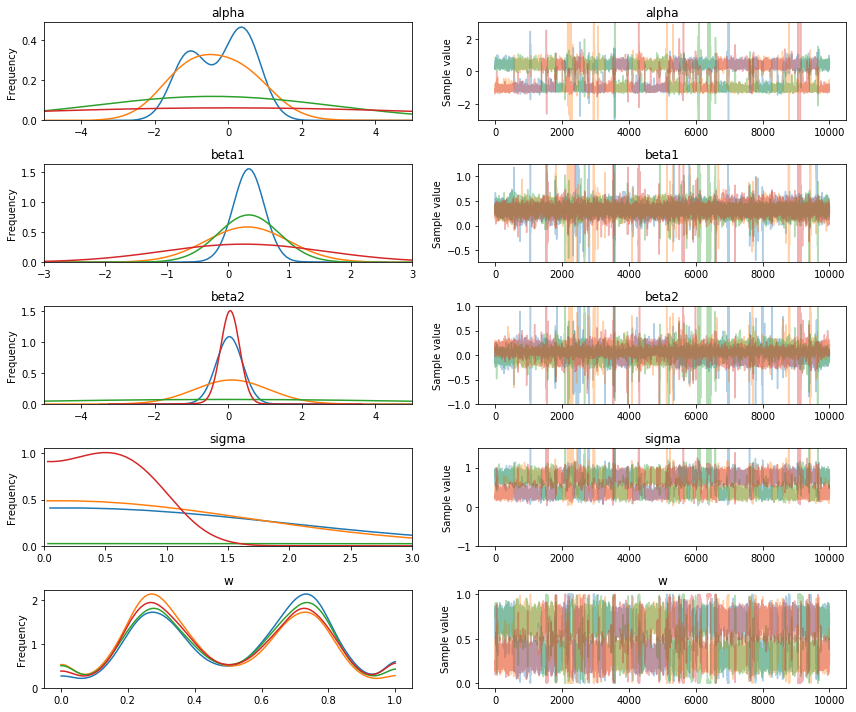

In [132]:
ax = pm.traceplot(traceK)
ax[0,0].set_xlim(-5,5)
ax[0,1].set_ylim(-3,3)
ax[1,0].set_xlim(-3,3)
ax[1,1].set_ylim(-.75,1.25)
ax[2,0].set_xlim(-5,5)
ax[2,1].set_ylim(-1,1)
ax[3,0].set_xlim(0,3)
ax[3,1].set_ylim(-1,1.5)
plt.show()

In [ ]:
# long chain: do model comparison
# try adding back beta3
# try adding interactions amongst variables x1, x2